In [1]:
import numpy as np 
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime,timedelta
import pandas as pd

import niskine
import mplniw.plot as pl
import gvpy as gv
import mplniw.sigp as sp
import mplniw.utils as ut

In [2]:
conf = niskine.io.load_config()
lon, lat, bottom_depth = niskine.io.mooring_location(mooring=1)
root_dir = '/Users/zcasparcohen/codes/NIW/'
figdir = '/Users/zcasparcohen/Documents/NISKINE/Figures/'

In [3]:
mooring=1
# Wind
wind_work = xr.open_dataset(root_dir+'data/ni_wind_work_niskine_m1.nc').rename({'__xarray_dataarray_variable__':'wind_work'})
wind_stress = xr.open_dataset(root_dir+'data/wind_work/wind_stress_niskine_m1.nc')

#Velocity time series
ds = xr.open_dataset(root_dir+'data/NI02_M%s.nc'%mooring)
gridded=xr.open_dataset(root_dir+'data/M%s_linear_merge_slinearfill.nc'%mooring)[['u','v']]
wkb = niskine.clim.get_wkb_factors(gridded)
ds['bpuz'] = wkb*ds['u_filtered'].differentiate('z')
ds['bpvz'] = wkb*ds['v_filtered'].differentiate('z')

ds['uz'] = ds['u'].differentiate('z')
ds['vz'] = ds['v'].differentiate('z')

#Vorticity
vort = xr.open_dataset(root_dir+'data/vorticity_moorings.nc')
vort_alt = xr.open_dataset(root_dir+'data/vorticity_alt.nc')

#N
N2 = xr.open_dataset(root_dir+'data/N_daily.nc').rename({'__xarray_dataarray_variable__':'N2'})

In [4]:
ds['KE_mld'] = ds.ni_ke_wkb.where(ds.z<ds.mld+100).mean('z')
ds['wind_work_diff'] = np.abs(wind_work['wind_work']).cumsum().differentiate('time')

In [5]:
events = ds.where((ds.KE_mld>0.001)&(ds.wind_work_diff>0.5e-16),drop=True)

In [6]:
max_days = 5
t_start = events.time.where((events.time.diff('time')*1e-9/3600).astype('int32')>(24*max_days),drop=True)
t_start = xr.concat([events.time[0],t_start],dim='time')
t_start = t_start[:-1]
t_end = events.time.roll(time=1).where((events.time.diff('time')*1e-9/3600).astype('int32')>24*max_days,drop=True)

In [7]:
tstart,tend = [],[]
for i in range(len(t_start)):
    if ds.sel(time=slice(t_start[i],t_end[i])).time.size>(24*6*max_days):
        tstart.append(t_start[i].time)
        tend.append(t_end[i].time)

In [8]:
t0,t1 = tstart,tend

In [7]:
t0,t1 = xr.open_dataset(root_dir+'data/tstart_M1.nc').time,xr.open_dataset(root_dir+'data/tend_M1.nc').time

Text(0.5, 1.0, '')

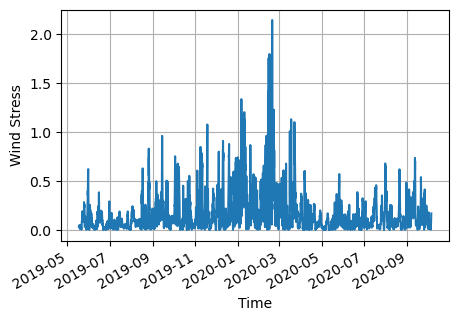

In [8]:
fig,ax = plt.subplots(figsize=(5,3))
wind_stress.__xarray_dataarray_variable__.plot(ax=ax)
ax.grid();ax.set_ylabel('Wind Stress');ax.set_xlabel('Time')
ax.set_title('')

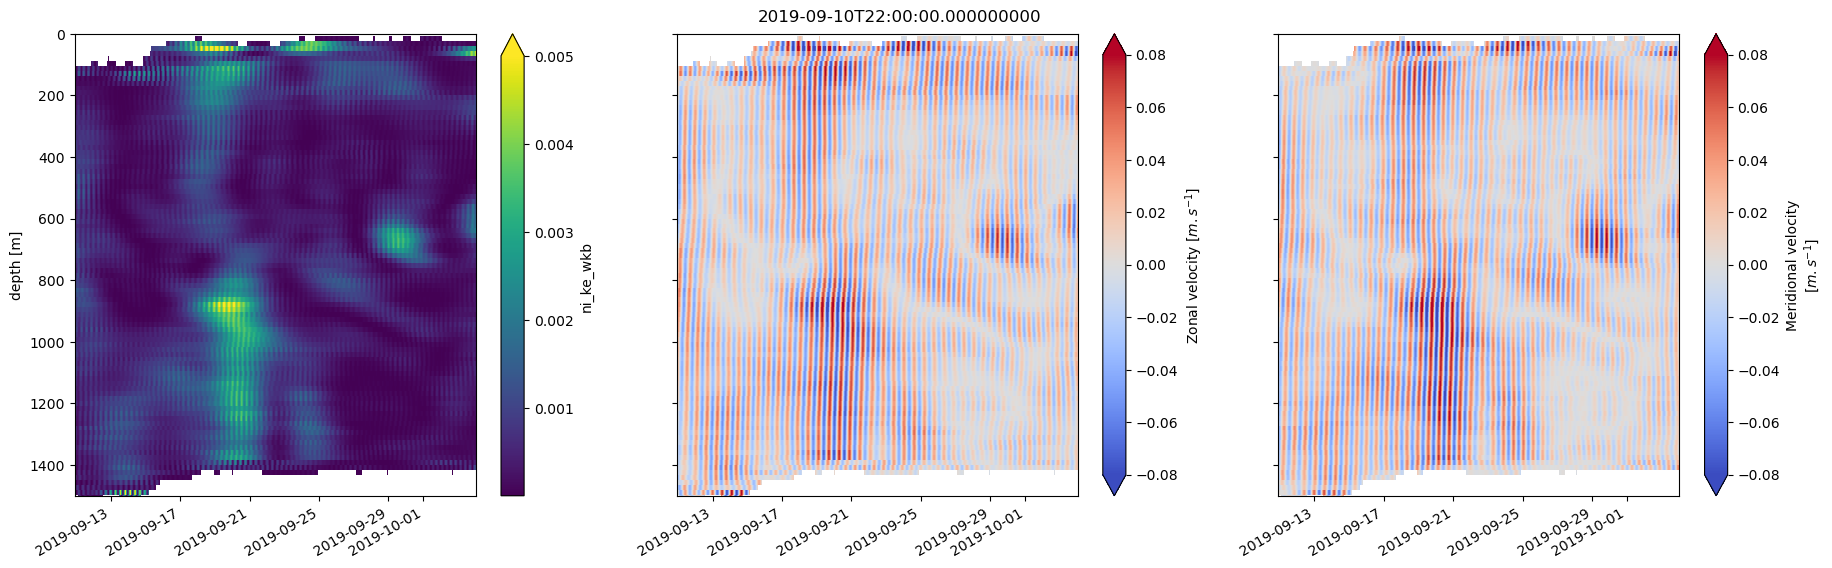

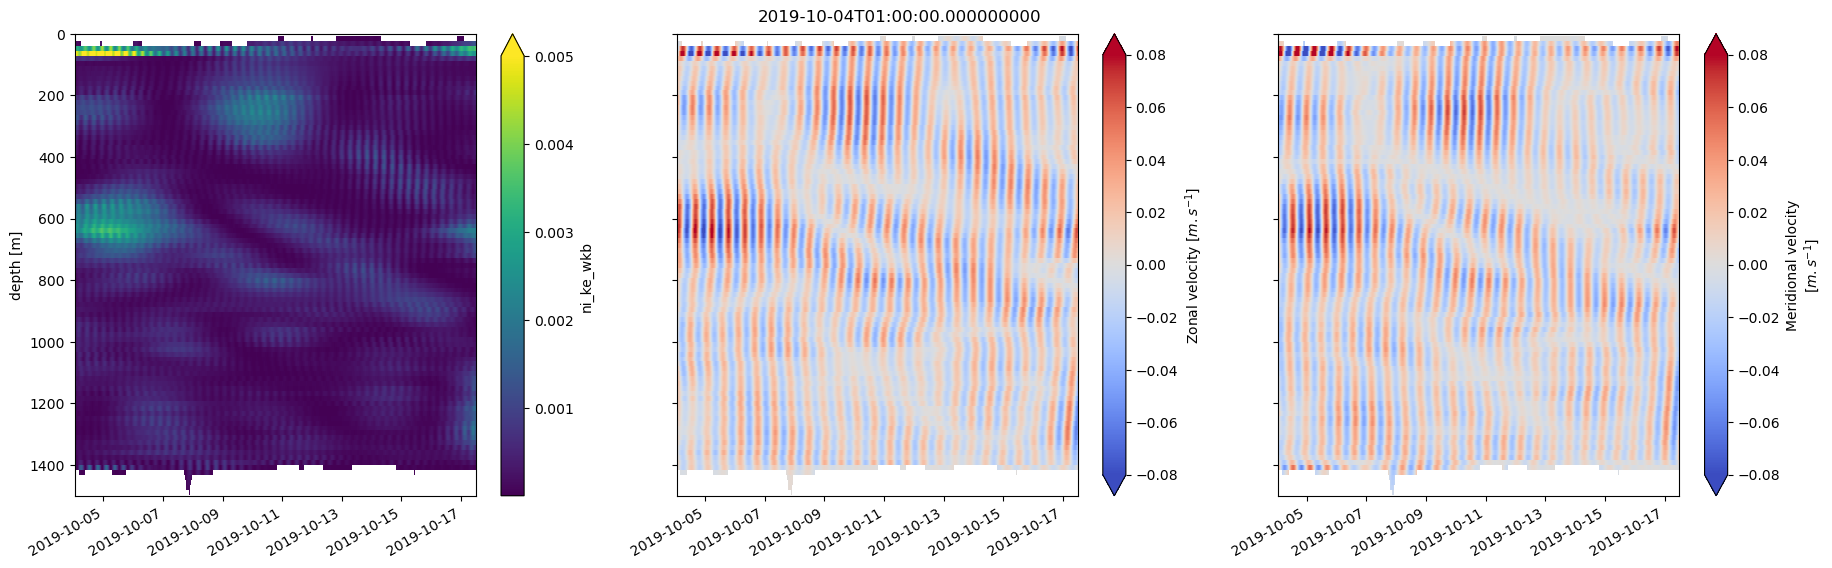

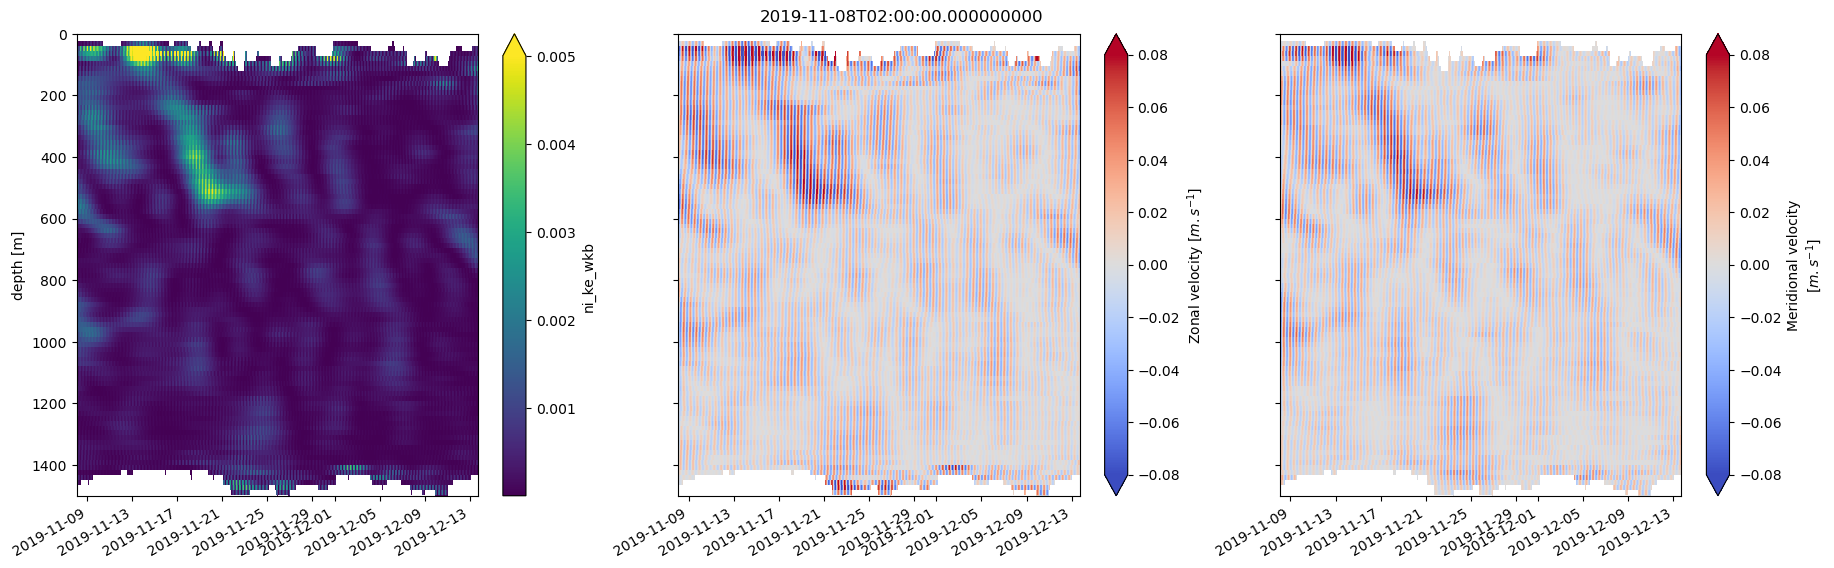

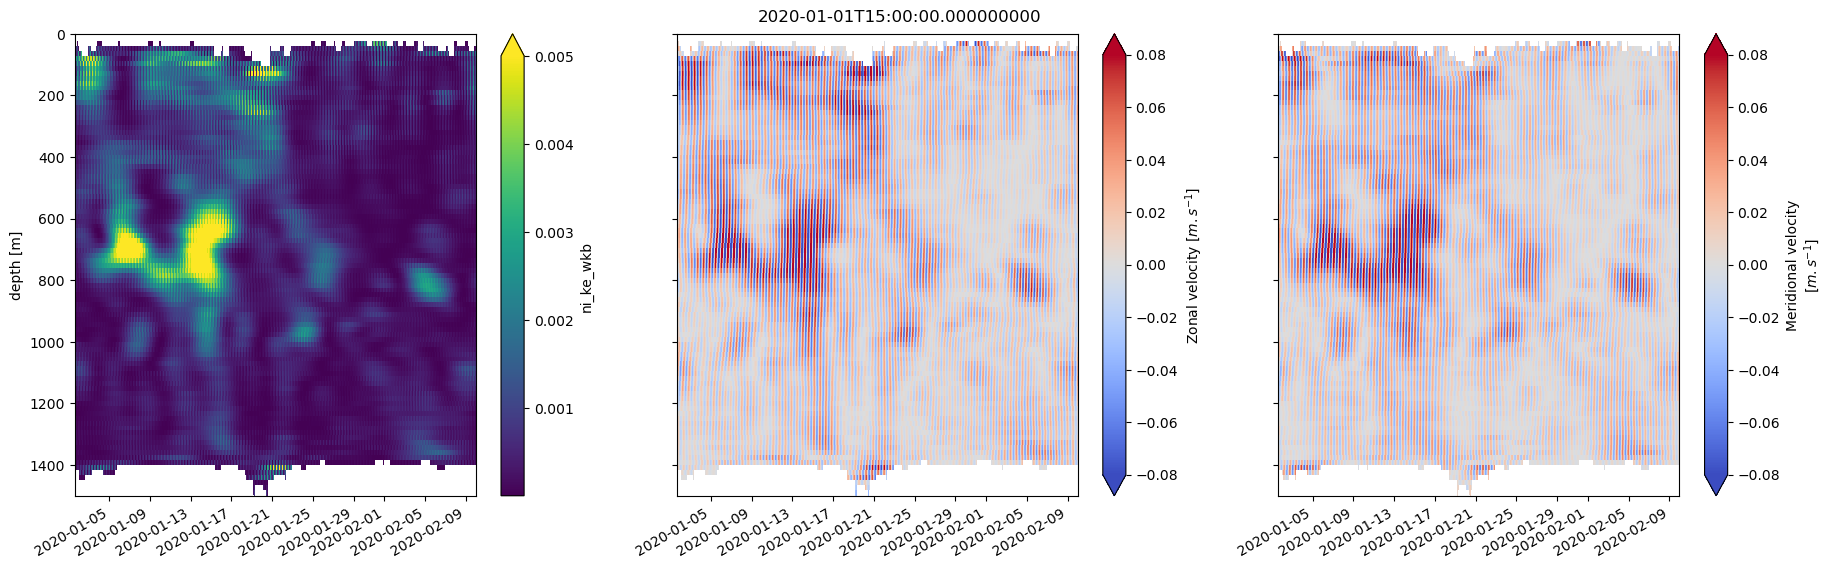

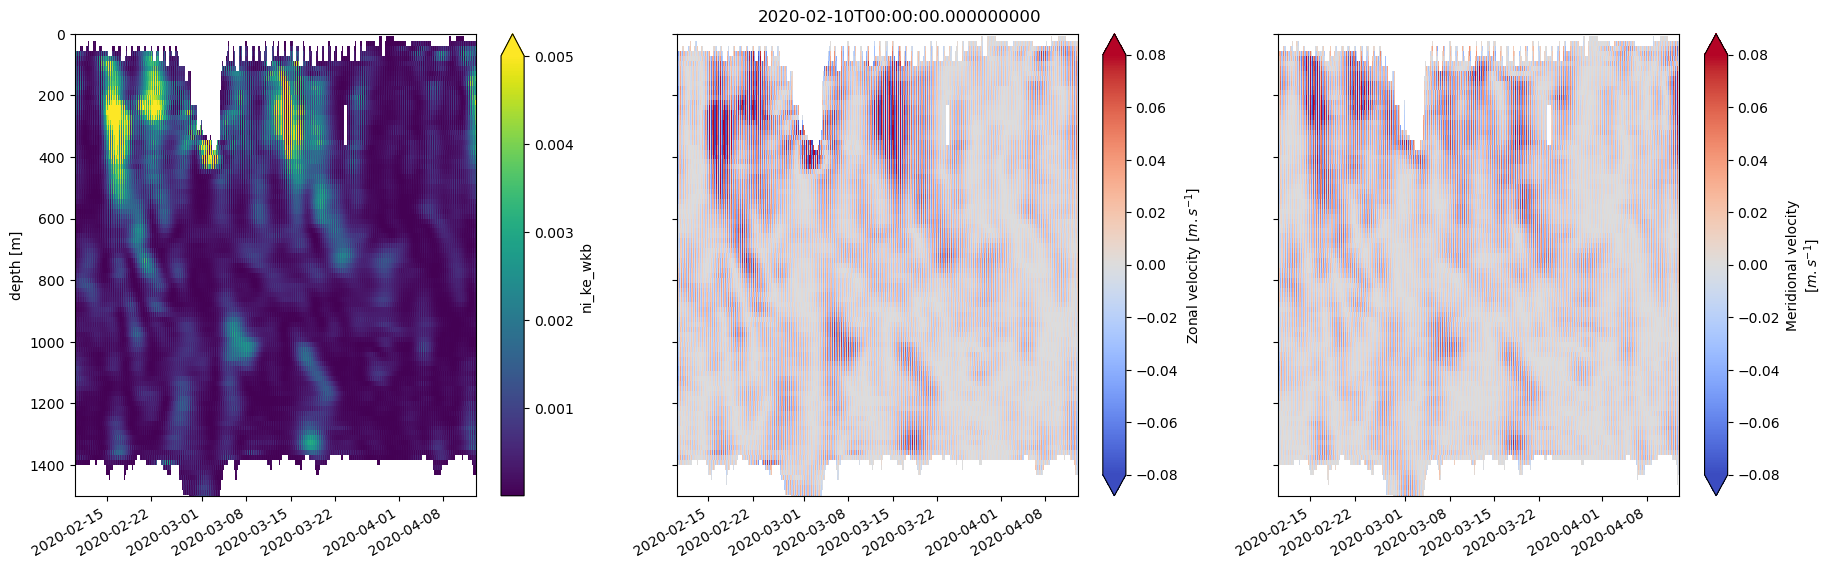

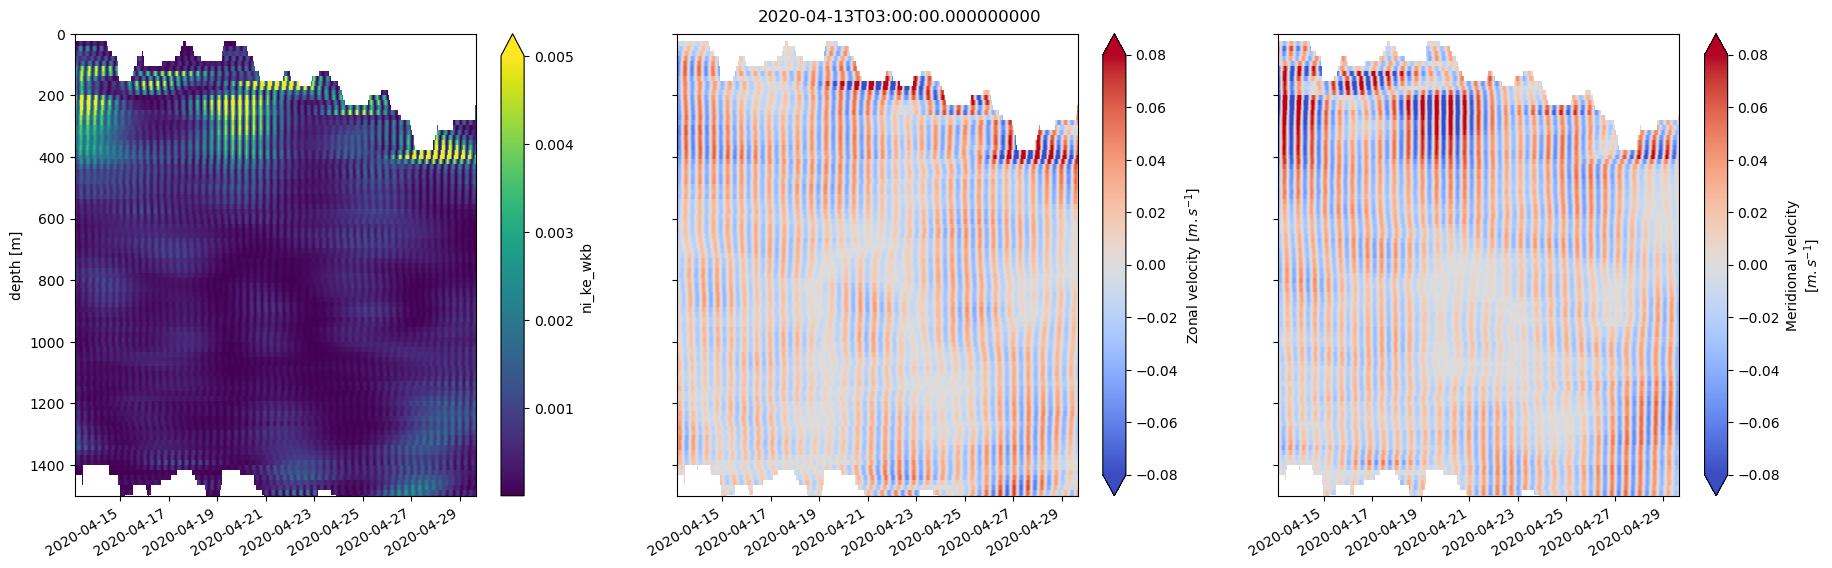

In [9]:
for index,ti in enumerate(t0):
    _time = ds.sel(time=slice(ti,t1[index])).time
    fig,axs = plt.subplots(1,3,figsize=(22,6))
    ax=axs[0]
    ds.ni_ke_wkb.sel(time=_time).plot(ax=ax,y='z',yincrease=False,vmax=0.005)
    #ax.tick_params(labelbottom=False);ax.set_xlabel('');
    ax.set_xlim(ti,t1[index]);
    ax.set_ylim(1500,0);ax.set_title('')
    #ax.axhline(mld_m1_argo.dt_m1.sel(month=months[index]),c='c',ls='-',lw=1.5)

    ax=axs[1]
    ds.bpu_wkb.sel(time=_time).plot(ax=ax,y='z',yincrease=False,vmax=0.08,cmap='coolwarm')
    #ax.tick_params(labelbottom=False);ax.set_xlabel('');
    ax.set_xlim(ti,t1[index]);ax.set_title('')
    ax.set_ylim(1500,0);
    #ax.axhline(mld_m1_argo.dt_m1.sel(month=months[index]),c='c',ls='-',lw=1.5)
    ax.tick_params(labelleft=False);ax.set_ylabel('')
    ax=axs[2]
    ds.bpv_wkb.sel(time=_time).plot(ax=ax,y='z',yincrease=False,vmax=0.08,cmap='coolwarm')
    #ax.tick_params(labelbottom=False);ax.set_xlabel('');
    ax.set_xlim(ti,t1[index]);ax.set_title('')
    ax.set_ylim(1500,0);
    #ax.axhline(mld_m1_argo.dt_m1.sel(month=months[index]),c='c',ls='-',lw=1.5);
    ax.tick_params(labelleft=False);ax.set_ylabel('')
    fig.suptitle(ti.values,x=.5,y=.92)
    #fig.savefig(figdir+'M1_event%s_uv.png'%index)

In [92]:
t0_event,t1_event = [],[]
for index,ti in enumerate(t0):
    _ds = ds.sel(time=slice(ti,t1[index]))
    _t  = _ds.where(np.abs(_ds.KE_mld.rolling(time=12*24).mean())>0.001,drop=True).time.values
    tt = np.array(_t[0])
    tmid  = _t[np.where(np.diff(_t).astype('float64')>24*6e11)]
    for i in range(len(tmid)):
        tt = np.insert(tt,-1,tmid[i])
        tt = np.insert(tt,-1,_t[np.where(_t==tmid[-1])[0]+1])
        #tt.append(_t[np.where(_t==tmid)[0]-1])
    tt= np.insert(tt,-1,_t[-1])
    #_ = [np.array(t) for t in tt]
    _time = _ds.sel(time=tt,method='nearest').time.values
    t0_event.append(_time[::2])
    t1_event.append(_time[1::2])

In [99]:
#print(t0_event[-1],t1_event[-1], _time)
_0,_1  =np.array(t0_event[0]),np.array(t1_event[0])
for i in range(len(t0_event)):
    _0 = np.insert(_0,-1,t0_event[i])
    _1 = np.insert(_1,-1,t1_event[i])

In [103]:
ds.sel(time=_0).time.to_netcdf(root_dir+'data/t0event_m1.nc')
ds.sel(time=_1).time.to_netcdf(root_dir+'data/t1event_m1.nc')

In [104]:
t0event = xr.open_dataset(root_dir+'data/t0event_m1.nc')
t1event = xr.open_dataset(root_dir+'data/t1event_m1.nc')

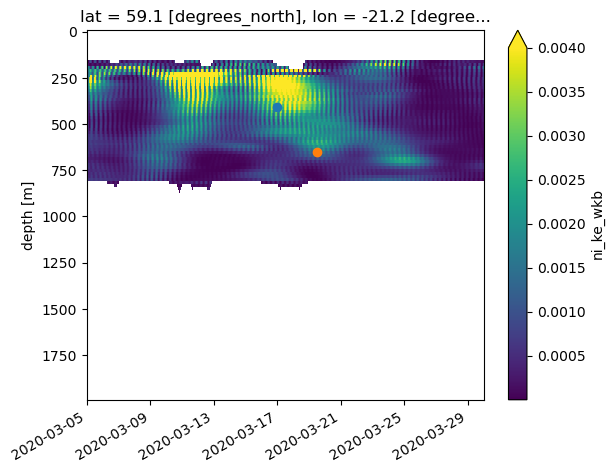

In [194]:
t0,t1 = '2020-03-05','2020-03-29'
t,tbis = '2020-03-17T00:00:000','2020-03-19T12:00:000'
z,zbis = _ds.mld.sel(time=t,method='nearest').values,650#_ds.mld.sel(time=t,method='nearest').values, 550
_ds = ds.sel(time=slice(t0,t1))
_ds.ni_ke_wkb.plot(yincrease=False,vmax=0.004)
plt.scatter(_ds.mld.sel(time=t,method='nearest').time.values, z)
plt.scatter(_ds.mld.sel(time=tbis,method='nearest').time.values, zbis)
#ds.sel(time=slice(t0,t1)).mld.plot(yincrease=False)

In [192]:
print(t,tbis)
print(z,zbis)

2020-03-17T00:00:000 2020-03-19T12:00:000
405.41984732824426 600


In [291]:
t = ['2020-01-03T12:00:00','2020-01-03T00:00:00','2019-11-14T12:00:00','2019-11-14T12:00:00','2020-02-15','2020-02-17','2020-03-17','2020-03-17']
tbis = ['2020-01-06T00:00:00','2020-01-04','2019-11-19','2019-11-19','2020-02-20T12','2020-03-21T12','2020-03-22T12','2020-03-19T12']
z = [330,352,129,129,431,538,405,405]
zbis = [750,600,600,600,800,800,750,600]

In [292]:
dt,dz,cg = [],[],[]
for i in range(len(t)):
    dt.append((_ds.ni_.sel(time=tbis[i],method='nearest').time.values - _ds.mld.sel(time=t[i],method='nearest').time.values).astype(float)*1e-9/(3600*24))
    dz.append(zbis[i] - z[i])
    cg.append(dz[i] / dt[i])

/var/folders/vl/tj6snrv54zd212pkvk5g_l140000gn/T/ipykernel_1322/2837307878.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  cg.append(dz[i] / dt[i])


In [303]:

_ds.ni_ke_wkb.sel(time=tbis[0]).time.values
#(_ds.mld.sel(time=tbis[i],method='nearest').time.values - _ds.mld.sel(time=t[i],method='nearest').time.values).astype(float)*1e-9/(3600*24)

KeyError: "not all values found in index 'time'. Try setting the `method` keyword argument (example: method='nearest')."

#### Dev

In [200]:
mooring=3
# Wind
wind_work = xr.open_dataset(root_dir+'data/ni_wind_work_niskine_m1.nc').rename({'__xarray_dataarray_variable__':'wind_work'})
wind_stress = xr.open_dataset(root_dir+'data/wind_work/wind_stress_niskine_m1.nc')

moorings = {}
for mooring in [1,2,3]:
#Velocity time series
    ds = xr.open_dataset(root_dir+'data/NI02_M%s.nc'%mooring)
    gridded=xr.open_dataset(root_dir+'data/M%s_linear_merge_slinearfill.nc'%mooring)[['u','v']]
    wkb = niskine.clim.get_wkb_factors(gridded)
    ds['bpuz'] = wkb*ds['u_filtered'].differentiate('z')
    ds['bpvz'] = wkb*ds['v_filtered'].differentiate('z')

    ds['uz'] = ds['u'].differentiate('z')
    ds['vz'] = ds['v'].differentiate('z')
    ds['KE_mld'] = ds.ni_ke_wkb.where(ds.z<ds.mld+100).mean('z')
    ds['wind_work_diff'] = np.abs(wind_work['wind_work']).cumsum().differentiate('time')
    moorings['M%s'%mooring] = ds
#Vorticity
vort = xr.open_dataset(root_dir+'data/vorticity_moorings.nc')
vort_alt = xr.open_dataset(root_dir+'data/vorticity_alt.nc')

#N
N2 = xr.open_dataset(root_dir+'data/N_daily.nc').rename({'__xarray_dataarray_variable__':'N2'})



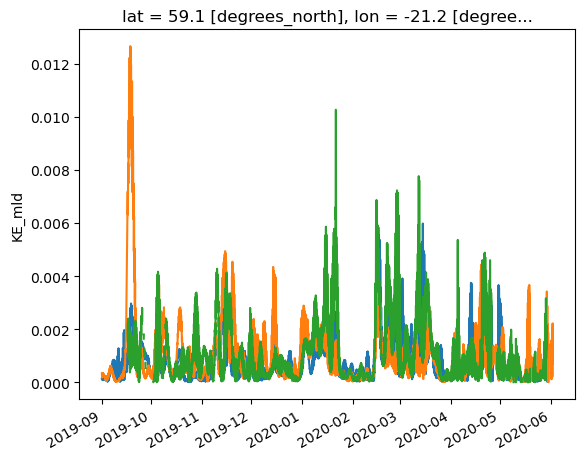

In [201]:
for m in [1,2,3]:
    moorings['M%s'%m].KE_mld.sel(time=slice('2019-09-01','2020-06-01')).plot()

In [204]:
t_start,t_end = xr.open_dataset(root_dir+'data/tstart_M1.nc').time,xr.open_dataset(root_dir+'data/tend_M1.nc').time

In [228]:
t_start

<xarray.DataArray 'time' (time: 4)>
array(['2019-09-10T22:00:00.000000000', '2019-11-08T02:00:00.000000000',
       '2019-12-13T17:00:00.000000000', '2020-02-10T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2019-09-10T22:00:00 ... 2020-02-10
    lat      float64 ...
    lon      float64 ...
Attributes:
    long_name:

2019-11-08T02:00:00.000000000
2019-12-13T17:00:00.000000000
2020-02-10T00:00:00.000000000
2020-04-13T03:00:00.000000000


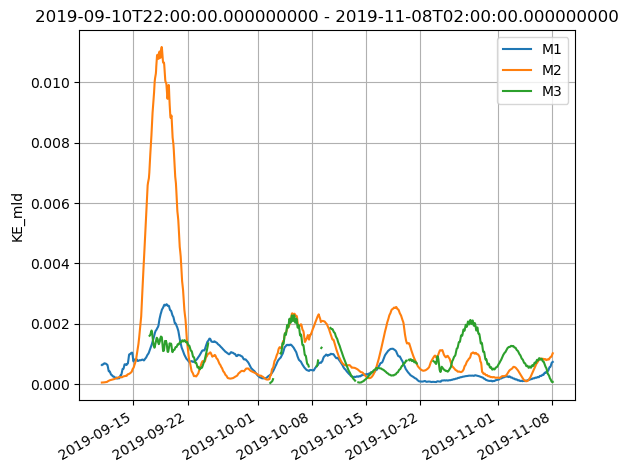

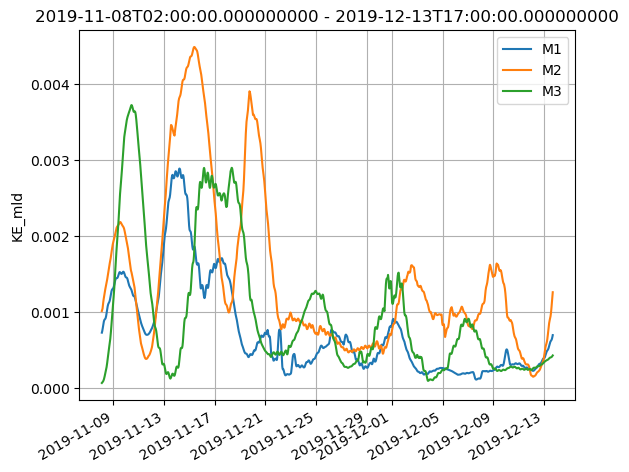

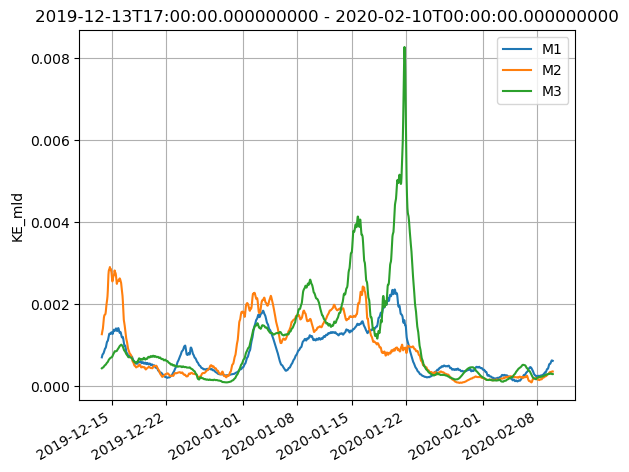

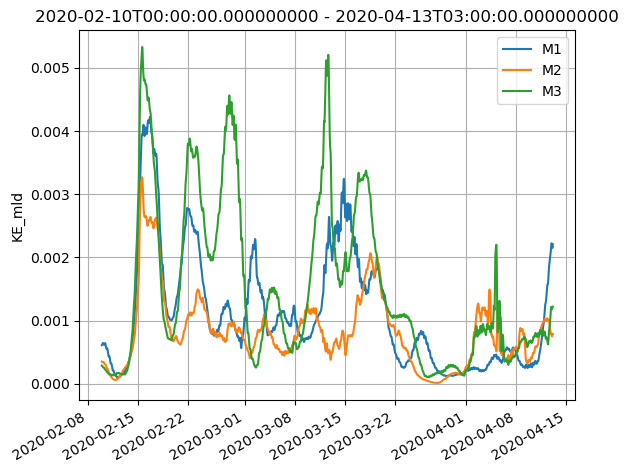

In [226]:
for t0,t1 in zip(t_start,t_end):
    print(t1.values)
    plt.figure()
    for m in [1,2,3]:
        moorings['M%s'%m].KE_mld.rolling(time=40).mean().sel(time=slice(t0,t1)).plot(label='M%s'%m)
    plt.grid();plt.legend()
    plt.title('%s - %s'%(t0.values,t1.values))

In [219]:
for m in [1,2,3]:
    moorings['M%s'%m]['KE_below'] = moorings['M%s'%m].ni_ke_wkb.where(moorings['M%s'%m].z>moorings['M%s'%m].mld,drop=True)

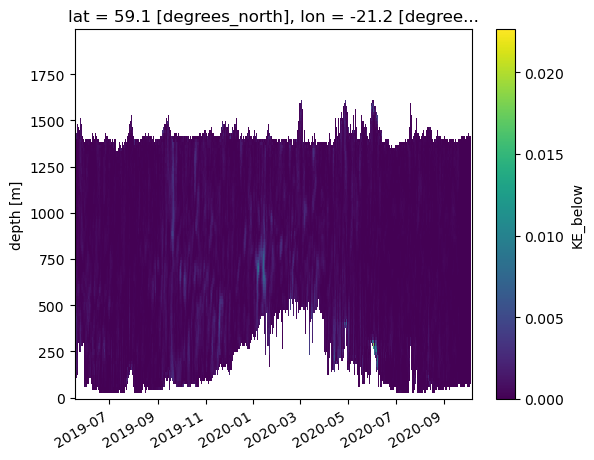

In [220]:
moorings['M%s'%1].KE_below.plot()

In [229]:
vort

<xarray.Dataset>
Dimensions:         (time: 73057, z: 125)
Coordinates:
  * time            (time) datetime64[ns] 2019-05-17T16:00:00 ... 2020-10-06
  * z               (z) int64 0 16 32 48 64 80 ... 1904 1920 1936 1952 1968 1984
Data variables:
    vorticity       (z, time) float64 ...
    vorticity_norm  (z, time) float64 ...
    vorticity_z     (z, time) float64 ...

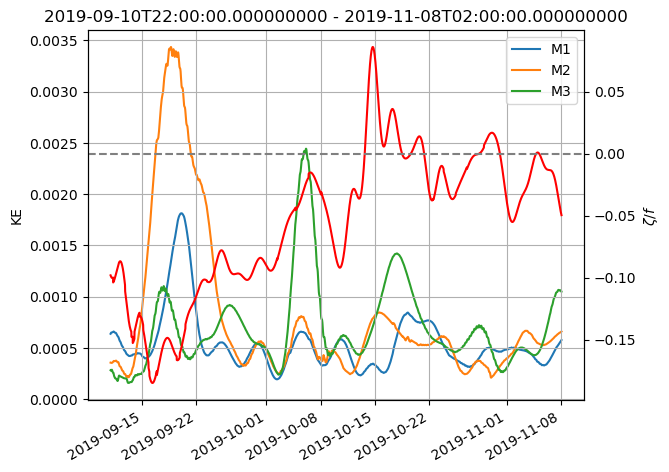

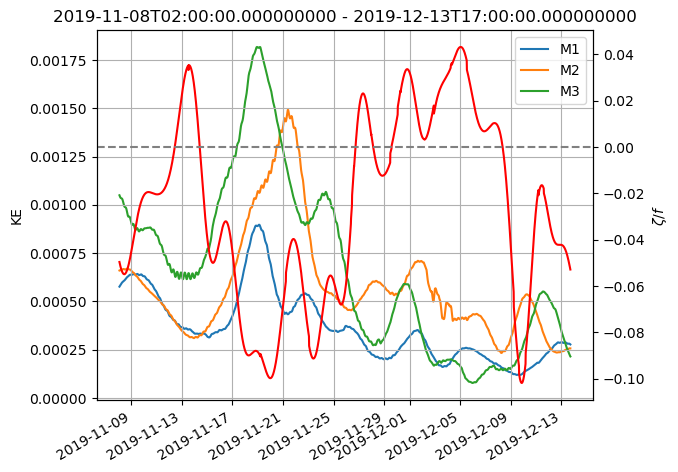

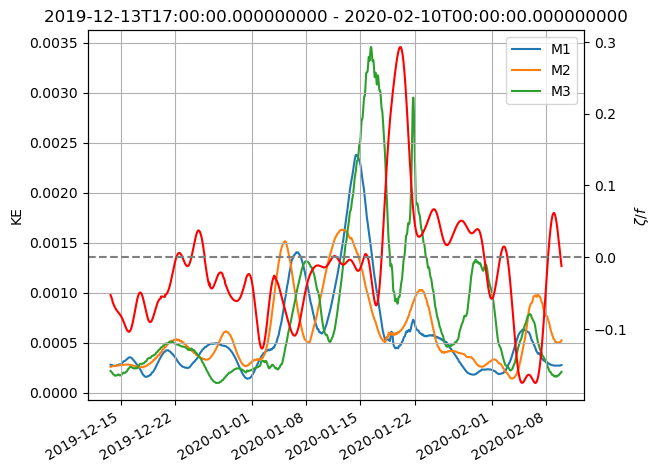

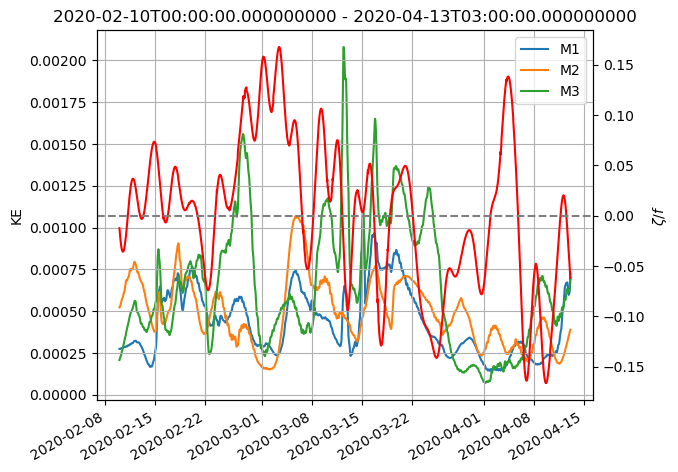

In [239]:
for t0,t1 in zip(t_start,t_end):
    fig,ax = plt.subplots()
    for m in [1,2,3]:
        moorings['M%s'%m].KE_below.mean('z').rolling(time=40).mean().sel(time=slice(t0,t1)).plot(ax=ax,label='M%s'%m,zorder=0)
    ax.grid();ax.legend()
    ax1 = ax.twinx()
    ax1.axhline(0,c='grey',ls='--')
    vort.vorticity_norm.sel(time=slice(t0,t1)).mean('z').plot(ax=ax1,c='r',zorder=-1)
    ax.set_title('%s - %s'%(t0.values,t1.values))
    ax.set_ylabel('KE');ax1.set_ylabel(r'$\zeta / f$')

Text(0, 0.5, '')

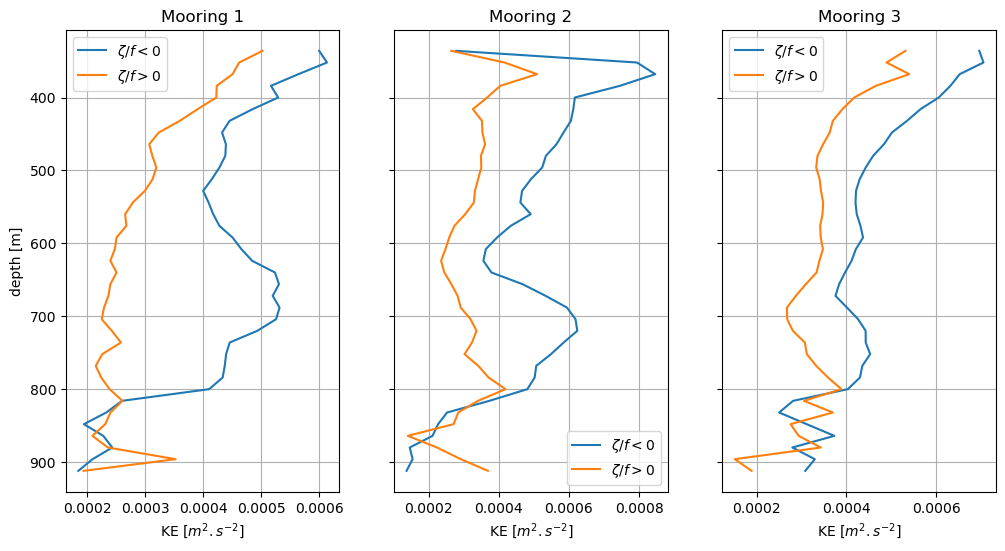

In [260]:
fig,axs = plt.subplots(1,3,figsize=(12,6),sharey=True)
for ax,m in zip(axs,[1,2,3]):
    moorings['M%s'%m].ni_ke_wkb.where(vort.vorticity_norm<0).mean('time').plot(ax=ax,y='z',yincrease=False,label=r'$\zeta / f < 0$')
    moorings['M%s'%m].ni_ke_wkb.where(vort.vorticity_norm>0).mean('time').plot(ax=ax,y='z',yincrease=False,label=r'$\zeta / f > 0$')
    ax.grid();ax.legend();ax.set_xlabel(r'KE [$m^2.s^{-2}$]')
    ax.set_title('Mooring %s'%m)
axs[1].set_ylabel('');axs[2].set_ylabel('')
#fig.tight_layout()

In [262]:
np.average(moorings['M1'].ni_ke_wkb)

nan

In [127]:
value = _ds.ni_ke_wkb.differentiate('z').sel(z=752).min().values
#value
_ds.where(_ds.ni_ke_wkb.differentiate('z').sel(z=752)<=value).u.dropna('time')


<xarray.DataArray 'u' (z: 125, time: 0)>
array([], shape=(125, 0), dtype=float64)
Coordinates:
  * time     (time) datetime64[ns] 
  * z        (z) int64 0 16 32 48 64 80 96 ... 1904 1920 1936 1952 1968 1984
    lat      float64 59.1
    lon      float64 -21.2
Attributes:
    long_name:  u
    units:      m/s

In [115]:
dsi = _ds.KE_mld.where(_ds.KE_mld==_ds.KE_mld.max(),drop=True)
dsf = _ds.where(_ds.ni_ke_wkb.differentiate('z').sel(z=750,method='nearest')==_ds.ni_ke_wkb.differentiate('z').sel(z=750,method='nearest').min(),drop=True)

IndexError: dimension coordinate 'z' conflicts between indexed and indexing objects:
<xarray.DataArray 'z' (z: 125)>
array([   0,   16,   32,   48,   64,   80,   96,  112,  128,  144,  160,  176,
        192,  208,  224,  240,  256,  272,  288,  304,  320,  336,  352,  368,
        384,  400,  416,  432,  448,  464,  480,  496,  512,  528,  544,  560,
        576,  592,  608,  624,  640,  656,  672,  688,  704,  720,  736,  752,
        768,  784,  800,  816,  832,  848,  864,  880,  896,  912,  928,  944,
        960,  976,  992, 1008, 1024, 1040, 1056, 1072, 1088, 1104, 1120, 1136,
       1152, 1168, 1184, 1200, 1216, 1232, 1248, 1264, 1280, 1296, 1312, 1328,
       1344, 1360, 1376, 1392, 1408, 1424, 1440, 1456, 1472, 1488, 1504, 1520,
       1536, 1552, 1568, 1584, 1600, 1616, 1632, 1648, 1664, 1680, 1696, 1712,
       1728, 1744, 1760, 1776, 1792, 1808, 1824, 1840, 1856, 1872, 1888, 1904,
       1920, 1936, 1952, 1968, 1984])
Coordinates:
  * z        (z) int64 0 16 32 48 64 80 96 ... 1904 1920 1936 1952 1968 1984
    lat      float64 ...
    lon      float64 ...
Attributes:
    long_name:  depth
    units:      m
vs.
<xarray.Variable ()>
array(752)
Attributes:
    long_name:  depth
    units:      m

In [106]:
ti, zi  = dsi.time, _ds.mld.sel(time=dsi.time).values
tf, zf  = dsf.time, dsf.z

In [107]:
print('t0:', ti.values)
print('t1:', tf.values)

t0: ['2020-02-16T15:20:00.000000000']
t1: ['2020-02-16T19:40:00.000000000']


In [96]:
dt = (tf.values-ti.values)*1e-9/(3600*24) # days

In [97]:
cg = (zf-zi).values / dt.tolist() # m.day-1

/var/folders/vl/tj6snrv54zd212pkvk5g_l140000gn/T/ipykernel_9420/3556133648.py:1: RuntimeWarning: divide by zero encountered in divide
  cg = (zf-zi).values / dt.tolist() # m.day-1


In [98]:
cg

array([inf])

In [130]:
M1_t0 = np.array(['2019-11-14T12:00:00','2020-01-03T12:00:00','2020-02-15','2020-03-17T00:00:00'])
M1_t1 = np.array(['2019-11-19','2020-01-06T00:00:00','2020-02-20T12:00:00','2020-03-22T12:00:00'])

M1_z0 = np.array([129,330,431,405])
M1_z1 = np.array([600,750,800,750])

#M2
M2_t0 = np.array(['2020-01-03T00:00:00','2020-02-17','2020-03-17T00:00:00'])
M2_t1 = np.array(['2020-01-04T00:00:00','2020-02-21T12:00:00','2020-03-19T12:00:00'])

M2_z0 = np.array([352,538,405])
M2_z1 = np.array([600,800,600])

#M3
M3_t0 = np.array(['2019-11-14T12:00:00'])
M3_t1 = np.array(['2019-11-19'])

M3_z0 = np.array([129])
M3_z1 = np.array([600])

In [131]:
M1_cg = (M1_z1-M1_z0) / ((M1_t1.astype('datetime64')-M1_t0.astype('datetime64')).astype('float64')/3600/24)
M2_cg = (M2_z1-M2_z0) / ((M2_t1.astype('datetime64')-M2_t0.astype('datetime64')).astype('float64')/3600/24)
M3_cg = (M3_z1-M3_z0) / ((M3_t1.astype('datetime64')-M3_t0.astype('datetime64')).astype('float64')/3600/24)

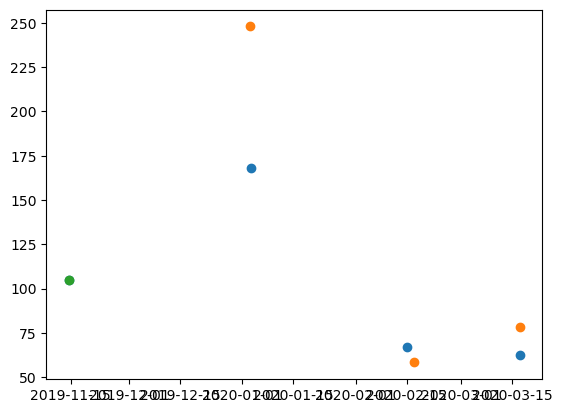

In [132]:
plt.scatter(M1_t0.astype('datetime64'),M1_cg)
plt.scatter(M2_t0.astype('datetime64'),M2_cg)
plt.scatter(M3_t0.astype('datetime64'),M3_cg)